# Portfolio Optimization using MOPSO

## Problem Statement
Assume that you are a financial consultant and you have to create a portfolio for your client. You have two objectives: 
1. Maximize the expected return of the portfolio
2. Minimize the risk associated with the portfolio <br>

In the attached file, the data of 20 stocks from 4 different industries is provided. <br>
Since diversification helps in minimizing risk, two constraints are imposed on the weights associated with each stock in the portfolio. First, to reduce emphasize on a particular stock, each stock must account for no more than 15% of the total portfolio. In addition, the proportion of an industry must not exceed 40% of the total portfolio.<br> 
Use the MOPSO algorithm to make appropriate investment suggestion. Show the transitions of Pareto fronts over iterations in a YouTube video.<br>
<a href="https://drive.google.com/open?id=1qLS5UUMQ6RlpyVfpEW0ZWbFOQi331j8q&authuser=0">Stock_Information.xls</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from MOPSO import mopsoOptimizer
from MOPSO import *

In [2]:
def read_csv(filpath="./Stock_information.csv"):
    """
    Reads the 3 tables from the given fil path and returns as 3 pandas data frame, 
    for the above given stock information
    """
    df = pd.read_csv(filpath)
    industry = df.iloc[:5, :2]
    stocksData = df.iloc[7:10,:]
    covarianceMatrix = df.iloc[15:,:]
    
    stocksData = np.float32(stocksData.iloc[1:,1:])
    covarianceMatrix = np.float32(covarianceMatrix.iloc[1:,1:])
    return (industry, stocksData, covarianceMatrix)

In [3]:
#get data
industry, stocksData, covarianceMatrix = read_csv()
ER = stocksData[0,:]
variance = stocksData[1,:]

In [4]:
#cost_functions
def evalExpectedReturn(weights, expectedReturns=ER):
    """
    Evaluates the expected return of the portfolio using the given weights and expected returns
    of each asset
    Arg:
        weights (array) - array of size (1, nAssets) of weight assosciated with each asset
        expected return (array) - array of size (1, nAssests) of expected return of each asset
    Return:
        Expected return of the portfolio (float)
    """
    
    weights = np.array(weights).reshape(1,-1)
    expectedReturns = np.array(expectedReturns).reshape(1,-1)
    return np.dot(expectedReturns, weights.T).squeeze() + 0 #+0 to convert to real no. instead of array


def evalRisk(weights, variance=variance, covariance=covarianceMatrix):
    """
    Returns the risk associated with the portfolio (float)
    Args:
        weights - for each stock, shape
        variance - for each stock
        covariance -for all stock combination in format   A1..A5 B1..D1..D5
                                                        A1 .   .
                                                        .
                                                        .
                                                        .
                                                        D5
    """
    weights, variance = np.array(weights).reshape(1,-1), np.array(variance).reshape(1,-1)
    weightSqrd = np.power(weights, 2)
    
    weightsRepeated1 = np.repeat(weights, weights.shape[1],0)
    weightsRepeated2 = np.repeat(weights.T, weights.shape[1],1)
    
    sdRepeated1 = np.repeat(np.sqrt(variance), variance.shape[1], 0)
    sdRepeated2 = np.repeat(np.sqrt(variance.T), variance.shape[1], 1)
    
    riskSquared = np.dot(weightSqrd, variance.T).squeeze() + np.sum(covariance * weightsRepeated1 *
                                                                    weightsRepeated2 * sdRepeated1 *
                                                                    sdRepeated2)
    return riskSquared**0.5


Both the values are same hence correct

In [5]:
#sanity check
weights = np.ones((1,5))
variance = np.ones((1,5))
covar = np.ones((5,5))
evalRisk(weights, variance, covar)

5.477225575051661

should be equal to 30^0.5 = 5.477225575051661

In [6]:
#constraints
def applyConstraint(weights, constraint1=0.15, constraint2=0.4, nindustries=4, nstocks = 5):
    """
    Applies the two constraints to the weights and modifies them, as mentioned in the problem
    nindustries - total no. of industries 
    nstocks - total no. of stocks in each industry
    """
    total = np.sum(weights)
    weights = np.minimum(weights, constraint1*total)
    
    for i in range(nindustries-1):
        if np.sum(weights[i*nstocks:(i+1)*nstocks])>constraint2*np.sum(weights):
            for j in range(i*nstocks,(i+1)*nstocks):
                weights[j]=constraint2*np.sum(weights)/nindustries
    return weights
#apply weight normalization
def normalizeWeight(weights):
    if np.sum(weights)!=1:
        weights = weights/(np.sum(weights)+0.000001)
    return weights 
    

In [7]:
population[0].position.size

NameError: name 'population' is not defined

In [7]:
##*******************************   Main.py    ***************************************## 

#PSO parameters
npop = 50
c1,c2 = 2,2
w = 1
wdamp = 0.99
niter = 100

#problem params
nvar = 20  # no. of stocks
varMin = 0  #since weigh shoul be in range 0 and 1
varMax = 1
maxVelocity = 0.2*(varMax-varMin)
minVelocity = -maxVelocity

#declare the helper functions
cost1 = evalExpectedReturn     # the one to maximize
cost2 = evalRisk       # the one to minimize
norm = normalizeWeight
constr = applyConstraint
population, pareto_list, GLOBAL_BEST = mopsoOptimizer(cost1, cost2, applyConstraint=constr,normalize=norm, 
                                                      npop = npop, nvar = nvar, varMax=varMax, varMin=varMin,
                                                      niter = niter ,c1=c1, c2=c2, w=w, wdamp=wdamp,
                                                      maxVelocity=maxVelocity, minVelocity=minVelocity)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [9]:
i = GLOBAL_BEST
print("Best weights for the 20 stocks :\n\n", i.position.reshape(1,-1).T)
print("\n\n")
print("Maximum Expected Return: %d \nMinimum Risk: %d" %(i.cost1, i.cost2))

Best weights for the 20 stocks :

 [[0.        ]
 [0.14999985]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.14999985]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.0999999 ]
 [0.14999985]
 [0.        ]
 [0.14999985]
 [0.14999985]
 [0.14999985]
 [0.        ]
 [0.        ]
 [0.        ]]





ValueError: cannot convert float NaN to integer

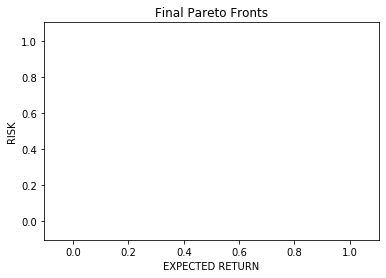

In [10]:
# plot the final pareto fronts
X = [i.cost1 for i in population]
Y = [i.cost2 for i in population]
plt.scatter(X,Y)
tmp = pareto_list[-1]
for front in tmp:
    X = np.array(tmp[front])[:,0]
    Y = np.array(tmp[front])[:,1]
    plt.plot(X,Y)
plt.xlabel("EXPECTED RETURN")
plt.ylabel("RISK")
plt.title("Final Pareto Fronts")
plt.show()

In [11]:
# Transiotion of pareto fronts over iteration
import matplotlib.animation as animation
def savePlots(pareto_list):
    f = 1
    count=1
    for paretoFront in pareto_list:
        f*=-1
        if f==-1:
            continue
      
        t= list(paretoFront.values())
        costs = []
        for i in t:
            costs = costs+i
        costs = np.array(costs)
        X = costs[:,0]
        Y = costs[:,1]
        plt.scatter(X,Y)
        for front in paretoFront:
            X = np.array(paretoFront[front])[:,0]
            Y = np.array(paretoFront[front])[:,1]
            plt.plot(X,Y)
        plt.xlabel("EXPECTED RETURN")
        plt.ylabel("RISK")
        plt.title("Pareto Fronts for iteration ",count)
        plt.show()
        plt.savefig("./images/graph"+str(count)+".jpg")
        plt.close()
        count+=1


AttributeError: 'int' object has no attribute 'pop'

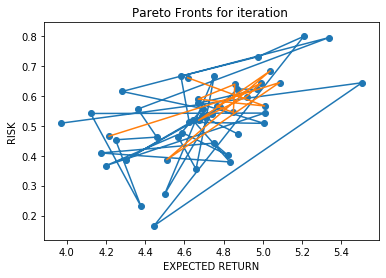

In [12]:
savePlots(pareto_list)


In [18]:
f = -1
for i in range(6):
    if f==1:
        continue
    
    print(i)

0
